<a href="https://colab.research.google.com/github/alexunderch/Master_materials/blob/main/nca/NCA_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Basic Imports

The majority of used code is taken from [here](https://distill.pub/2020/growing-ca/) and [here](https://github.com/chenmingxiang110/Growing-Neural-Cellular-Automata/blob/master/lib/CAModel.py). Thank you for the inspiration!

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from PIL import Image as pImage, ImageDraw as pImageDraw
import io
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
from copy import deepcopy
from IPython.display import Image, HTML, clear_output
from tqdm.notebook import tqdm


import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()

from typing import Tuple, Callable
import dataclasses
from dataclasses import dataclass, field

## Constants

In [ ]:
#@title Cellular Automata Parameters
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🦎" #@param {type:"string"}

EXPERIMENT_TYPE = "Regenerating" #@param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing": 0, "Persistent": 1, "Regenerating": 2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

## Utilities

In [ ]:
def np2pil(array: np.ndarray) -> Image:
    if array.dtype in [np.float32, np.float64]:
        array = np.uint8(np.clip(array, 0, 1) * 255)
    return pImage.fromarray(array)

def to_rgba(x):
    # we have CHANNEL_N by default
    return x[..., :4]

def to_alpha(x):
    return np.clip(x[..., 3:4], a_min = 0., a_max = 0.99999)

def to_rgb(x):
  # assume rgb premultiplied by alpha
  rgb, alpha = x[..., :3], to_alpha(x)
  return np.clip(1.0 - alpha + rgb, a_min = 0., a_max = 0.99999)

def make_seed(size: int, n: int = 1):
    x = np.zeros([n, size, size, CHANNEL_N], np.float32)
    x[:, size // 2, size // 2, 3:] = 1.0 
    return x

### loaders
def load_image(url: str, 
               max_size: int = TARGET_SIZE
               ) -> np.ndarray:
    r = requests.get(url)
    img = pImage.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), pImage.ANTIALIAS)
    img = np.float32(img) / 255.0
    # premultiply RGB by Alpha
    alpha  = img[..., 3:]
    img[..., :3] *= alpha
    return img

def load_emoji(emoji) -> np.ndarray:
    code = hex(ord(emoji))[2:].lower()
    url = 'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u%s.png?raw=true'%code
    return load_image(url)

# def load_custom_emoji(index: int, path: str):
#     im = imageio.imread(path)
#     emoji = np.array(im[:, index*40:(index+1)*40].astype(np.float32))
#     emoji /= 255.0
#     return emoji

## Model

In [ ]:
@dataclass(eq = False)
class LittleNCA(torch.nn.Module):
    def __post_init__(self):
        super().__init__()

    channels: int = field(default = CHANNEL_N)
    fire_rate: float =  field(default = CELL_FIRE_RATE)
    interm_channels: int = field(default = 128)
    
    def conv_setup(self, init: bool = False): 
        model = [
                    nn.Conv2d(self.channels * 3, self.interm_channels, 1, padding = 0),
                    nn.ReLU(),
                    nn.Conv2d(self.interm_channels, self.channels, 1, padding = 0, bias = False)    
                ]
        if init:
            with torch.no_grad():
                model[-1].weight.zero_()
        self.model = nn.Sequential(*model)
        return self


    @property
    def device(self):
        return next(self.parameters()).device

    def get_living_mask(self, x):
        stride_height, stride_width = (1, 1)
        out_height, out_width = (1, 1)

        alpha = x[:, 3:4, ...]
        return F.max_pool2d(
                                alpha,
                                kernel_size = 3,
                                stride = (int(stride_height), int(stride_width)),
                                padding = (int(out_height), int(out_width))
                            ) > 0.1
    @torch.no_grad()    
    def perceive(self,
                 x: torch.Tensor, 
                 angle: float = 0.0, 
                 step_size: float = 1.0):
        
        identify = np.float32([0, 1, 0])
        identify = np.outer(identify, identify)
        """
        identity = 
                    [[0. 0. 0.]
                    [0. 1. 0.]
                    [0. 0. 0.]]
        """
        
        dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
        """
        dx = 
                    [[-1  0  1]
                    [-2  0  2]
                    [-1  0  1]]        
        """
        
        dy = dx.T
        c, s = torch.cos(torch.tensor(angle)), torch.sin(torch.tensor(angle))
        
        #rotate percieved tensor on `angle`
        kernel = torch.stack([torch.Tensor(identify), c * dx - s * dy, s * dx + c * dy], dim = 0)[:, None, ...]
        kernel = kernel.repeat(self.channels, 1, 1, 1).to(torch.float32).to(self.device)
        kernel.requires_grad_ = False
    
        return F.conv2d(
            input  = x,
            weight = kernel,
            padding = 1,
            groups = self.channels,
            stride = (1, 1)
        )

    def forward(self, 
                x: torch.Tensor, 
                fire_rate: float = None, 
                angle: float = 0.0, 
                step_size: float = 1.0):
        
        if fire_rate is None:
            fire_rate = self.fire_rate

        x = x.transpose(1, 3)

        pre_life_mask = self.get_living_mask(x)
        y = self.perceive(x, angle = angle)
        dx = self.model(y) * step_size

        update_mask = torch.randn_like(x[:, :1, ...]) > fire_rate #> or <= ?
        update_mask = update_mask.float().to(self.device)
        x +=  dx * update_mask

        post_life_mask = self.get_living_mask(x)
        life_mask = (pre_life_mask & post_life_mask).float()

        out = x * life_mask
        return out.transpose(1, 3)

    def to_onnx(self, name: str):
        torch.onnx.export(self.state_dict(), (72, 72, 16), f'onnx_model_{name}.onnx', verbose=True)

In [ ]:
model = LittleNCA()
model.conv_setup(init = True)
summary(model = model, input_size = (3, 3, 16), batch_size = -1, device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 3, 3]           6,272
              ReLU-2            [-1, 128, 3, 3]               0
            Conv2d-3             [-1, 16, 3, 3]           2,048
Total params: 8,320
Trainable params: 8,320
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.03
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


## Training utils

In [ ]:
#copied from the notebook with tf -> torch modifications

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename, fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()

class SamplePool:
  def __init__(self, *, _parent = None, _parent_idx = None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      setattr(self, k, np.asarray(v))

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

def make_circle_masks(n, h, w):
    x = torch.linspace(-1.0, 1.0, w)[None, None, :]
    y = torch.linspace(-1.0, 1.0, h)[None, :, None]
    center = torch.distributions.uniform.Uniform(-.5 , .5).sample((2, n, 1, 1)) 
    r = torch.distributions.uniform.Uniform(.1 , .4).sample((n, 1, 1)) 
    x, y = (x - center[0]) / r, (y - center[1]) / r
    mask = x ** 2 + y ** 2 < 1.0
    return mask.to(torch.float32).numpy() 

def generate_pool_figures(pool, step_i):
    
    tiled_pool = tile2d(to_rgb(pool.x[:49]))
    fade = np.linspace(1.0, 0.0, 72)
    ones = np.ones(72) 
    tiled_pool[:, :72] += (-tiled_pool[:, :72] + ones[None, :, None]) * fade[None, :, None] 
    tiled_pool[:, -72:] += (-tiled_pool[:, -72:] + ones[None, :, None]) * fade[None, ::-1, None]
    tiled_pool[:72, :] += (-tiled_pool[:72, :] + ones[:, None, None]) * fade[:, None, None]
    tiled_pool[-72:, :] += (-tiled_pool[-72:, :] + ones[:, None, None]) * fade[::-1, None, None]
    imwrite('train_log/%04d_pool.jpg'%step_i, tiled_pool)

def visualize_batch(x0, x, step_i):
    vis0 = np.hstack(to_rgb(x0))
    vis1 = np.hstack(to_rgb(x))
    vis = np.vstack([vis0, vis1])
    imwrite('train_log/batches_%04d.jpg'%step_i, vis)
    print('batch (before/after):')
    imshow(vis)

def plot_loss(loss_log):
    pl.figure(figsize=(10, 4))
    pl.title('Loss history (log10)')
    pl.plot(np.log10(loss_log), '.', alpha=0.1)
    pl.show()


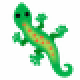

In [ ]:
#@title Target Emoji
target_img = load_emoji(TARGET_EMOJI)
imshow(zoom(to_rgb(target_img), 2), fmt='png')

## Training


In [ ]:
p = TARGET_PADDING
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
print(f"padded from {target_img.shape[:2]} to {pad_target.shape[:2]}")

h, w = pad_target.shape[:2]
seed = np.zeros([h, w, CHANNEL_N], np.float32)
seed[h // 2, w // 2, 3:] = 1.0

# os.system(
#     "!mkdir -p train_log && rm -f train_log/*"
# )

os.makedirs("train_log", exist_ok = True)
os.system(
     "rm -f train_log/*"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def loss_fn(inp, tgt, reduction: str = "mean"):
    inp = to_rgba(inp)
    if isinstance(inp, np.ndarray):
        inp = torch.Tensor(inp)
    if isinstance(tgt, np.ndarray):
        tgt = torch.Tensor(tgt)
    return F.mse_loss(inp, tgt, reduction = "mean")

@dataclass
class NCATrainer:
    seed: np.ndarray
    tgt_pattern: np.ndarray
    device: torch.device
    model: torch.nn.Module
    n_iterations_bounds: Tuple[int, int] 
    loss_fn: Callable
    optimizer: torch.optim
    lr_scheduler: Callable
    

    def __post_init__(self):
        self.model.to(self.device)
        self.loss_history = list()
        self.pool = SamplePool(x = np.repeat(self.seed[None, ...], POOL_SIZE, 0))
        self.tgt_pattern = np.repeat(self.tgt_pattern[None, ...], BATCH_SIZE, 0) \
                           if len(self.tgt_pattern.shape) < 4 else self.tgt_pattern

        self.tgt_pattern = torch.from_numpy(self.tgt_pattern.astype(np.float32)).to(self.device)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor]):
        n_iterations = int(np.random.randint(*self.n_iterations_bounds))
        inp, tgt = batch            

        for iter in range(n_iterations):
            preds = self.model(inp.to(self.device))

        self.optimizer.zero_grad()
        loss = self.loss_fn(preds, tgt.to(self.device))
        loss.backward()

        self.optimizer.step()
        self.lr_scheduler.step()

        return preds, loss
    
    def train(self, n_epochs):
        for epoch in tqdm(range(n_epochs + 1), total = n_epochs) :
            if USE_PATTERN_POOL:
                batch = self.pool.sample(BATCH_SIZE)
                x0 = batch.x.astype(np.float32)

                with torch.no_grad():    
                    loss_rank = F.mse_loss(torch.from_numpy(to_rgba(x0)).to(device), 
                                           self.tgt_pattern, 
                                           reduction = "none").mean((-2, -3, -1))
                    loss_rank = loss_rank.detach().cpu().numpy().argsort()[::-1]

                x0 = x0[loss_rank]
                x0[:1] = self.seed
                if DAMAGE_N:
                    damage = 1.0 - make_circle_masks(DAMAGE_N, h, w)[..., None]
                    x0[-DAMAGE_N:] *= damage
            else:
                x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)

            x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

            x, loss = self.training_step((x0, self.tgt_pattern))
            x, x0 = x.detach().cpu().numpy(), x0.detach().cpu().numpy()


            if USE_PATTERN_POOL:
                batch.x[:] = x
                batch.commit()

            step_i = len(self.loss_history)
            self.loss_history.append(loss.item())

            if step_i % 10 == 0:
                generate_pool_figures(self.pool, step_i)
            if step_i % 100 == 0:
                clear_output()
                visualize_batch(x0, x, step_i)
                plot_loss(self.loss_history)
                torch.save(self.model.state_dict(), 'train_log/%04d.pth'%step_i)

            print('\r step: %d, log10(loss): %.3f'%(len(self.loss_history), np.log10(loss.item())), end='')

print(f"device -- {device} -- used")
nca = LittleNCA().conv_setup(init = True).to(device)

lr = 2e-3
optimizer = torch.optim.Adam(params = nca.parameters(), lr = lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer = optimizer, gamma = .1, step_size = 2000)



padded from (40, 40) to (72, 72)
device -- cpu -- used


In [ ]:
trainer = NCATrainer(
    seed = seed,
    tgt_pattern = pad_target,
    device = device,
    model = nca,
    n_iterations_bounds = (64, 96),
    loss_fn = loss_fn,
    optimizer = optimizer,
    lr_scheduler = lr_scheduler
)

batch (before/after):


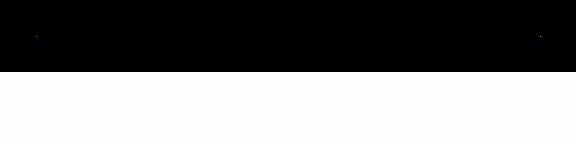

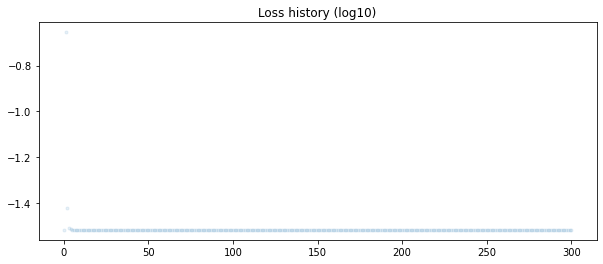

 step: 345, log10(loss): -1.516

In [ ]:
torch.autograd.set_detect_anomaly(True)
trainer.train(20_000)

## Experiments

In [ ]:
#@title Training Progress (Batches)
frames = sorted(glob.glob('train_log/batches_*.jpg'))
mvp.ImageSequenceClip(frames, fps=10.0).write_videofile('batches.mp4')
mvp.ipython_display('batches.mp4')

In [ ]:
#@title Pool Contents
frames = sorted(glob.glob('train_log/*_pool.jpg'))[-80:]
mvp.ImageSequenceClip(frames, fps=20.0).write_videofile('pool.mp4')
mvp.ipython_display('pool.mp4')

In [ ]:
#@title Training Progress (Checkpoints)

models = []
for i in [100, 500, 1000, 4000]:
  ca = CAModel()
  ca.load_weights('train_log/%04d'%i)
  models.append(ca)

out_fn = 'train_steps_damage_%d.mp4'%DAMAGE_N
x = np.zeros([len(models), 72, 72, CHANNEL_N], np.float32)
x[..., 36, 36, 3:] = 1.0
with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(500):
    vis = np.hstack(to_rgb(x))
    vid.add(zoom(vis, 2))
    for ca, xk in zip(models, x):
      xk[:] = ca(xk[None,...])[0]
mvp.ipython_display(out_fn)

In [ ]:
#@title Converting model to `onnx`-compatible format 
nca.to_onnx()
